**My turn**

[Первичный анализ](#1part)

[Дальнейшее исследование, добавление признаков](#2part)

[Быстрый вызов](#3part)

<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg" />
</center> 
     
## <center>  [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 

#### <center> Author: [Yury Kashnitsky](https://yorko.github.io) (@yorko) 

# <center>Assignment #2. Fall 2019
## <center> Part 2. Gradient boosting

**In this assignment, you're asked to beat a baseline in the ["Flight delays" competition](https://www.kaggle.com/c/flight-delays-fall-2018).**

This time we decided to share a pretty decent CatBoost baseline, you'll have to improve the provided solution.

Prior to working on the assignment, you'd better check out the corresponding course material:
 1. [Classification, Decision Trees and k Nearest Neighbors](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic03_decision_trees_kNN/topic3_decision_trees_kNN.ipynb?flush_cache=true), the same as an interactive web-based [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-3-decision-trees-and-knn) 
 2. Ensembles:
  - [Bagging](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic05_ensembles_random_forests/topic5_part1_bagging.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-5-ensembles-part-1-bagging)
  - [Random Forest](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic05_ensembles_random_forests/topic5_part2_random_forest.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-5-ensembles-part-2-random-forest)
  - [Feature Importance](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic05_ensembles_random_forests/topic5_part3_feature_importance.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-5-ensembles-part-3-feature-importance)
 3. - [Gradient boosting](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic10_boosting/topic10_gradient_boosting.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-10-gradient-boosting) 
   - Logistic regression, Random Forest, and LightGBM in the "Kaggle Forest Cover Type Prediction" competition: [Kernel](https://www.kaggle.com/kashnitsky/topic-10-practice-with-logit-rf-and-lightgbm) 
 4. You can also practice with demo assignments, which are simpler and already shared with solutions:
  - "Decision trees with a toy task and the UCI Adult dataset": [assignment](https://www.kaggle.com/kashnitsky/a3-demo-decision-trees) + [solution](https://www.kaggle.com/kashnitsky/a3-demo-decision-trees-solution)
  - "Logistic Regression and Random Forest in the credit scoring problem": [assignment](https://www.kaggle.com/kashnitsky/assignment-5-logit-and-rf-for-credit-scoring) + [solution](https://www.kaggle.com/kashnitsky/a5-demo-logit-and-rf-for-credit-scoring-sol)
 5. There are also 7 video lectures on trees, forests, boosting and their applications: [mlcourse.ai/video](https://mlcourse.ai/video) 
 6. mlcourse.ai tutorials on [categorical feature encoding](https://www.kaggle.com/waydeherman/tutorial-categorical-encoding) (by Wayde Herman) and [CatBoost](https://www.kaggle.com/mitribunskiy/tutorial-catboost-overview) (by Mikhail Tribunskiy)
 7. Last but not the least: [Public Kernels](https://www.kaggle.com/c/flight-delays-fall-2018/notebooks) in this competition

### Your task is to:
 1. beat **"A2 baseline (10 credits)"** on Public LB (**0.75914** LB score)
 2. rename your [team](https://www.kaggle.com/c/flight-delays-fall-2018/team) in full accordance with A1 and the [course rating](https://docs.google.com/spreadsheets/d/15e1K0tg5ponA5R6YQkZfihrShTDLAKf5qeKaoVCiuhQ/) (to appear on 16.09.2019)
 
This task is intended to be relatively easy. Here you are not required to upload your reproducible solution.
 
### <center> Deadline for A2: 2019 October 6, 20:59 CET (London time)

In [ ]:
0.75914 
0.75972

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import plotly_express as px
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from catboost import cv
from catboost import Pool
from matplotlib import pyplot as plt
from sklearn.preprocessing import scale


from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go


%matplotlib inline

**Read the data**

In [2]:
PATH_TO_DATA = Path('flight-delays-fall-2018/')

In [3]:
train_df = pd.read_csv('flight_delays_train.csv')

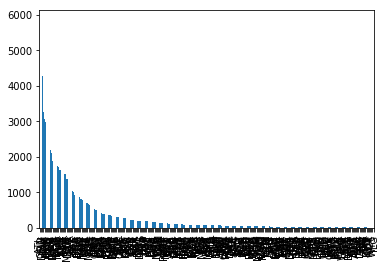

In [263]:
train_df['Origin'].value_counts().plot(kind='bar')

In [4]:
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [5]:
test_df = pd.read_csv('flight_delays_test.csv')

In [6]:
test_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


**Create only one feature - “flight” (this you need to improve - add more features)**

In [7]:
train_df['flight'] = train_df['Origin'] + '-->' + train_df['Dest']
test_df['flight'] = test_df['Origin'] + '-->' + test_df['Dest']

In [8]:
train_df.flight.head()

0    ATL-->DFW
1    PIT-->MCO
2    RDU-->CLE
3    DEN-->MEM
4    MDW-->OMA
Name: flight, dtype: object

**Remember indexes of categorical features (to be passed to CatBoost)**

In [15]:
categ_feat_idx = np.where(train_df.drop('dep_delayed_15min', axis=1).dtypes == 'object')[0]
categ_feat_idx

array([0, 1, 2, 4, 5, 6, 8], dtype=int64)

**Allocate a hold-out set to validate the model**

In [15]:
X_train = train_df.drop('dep_delayed_15min', axis=1)
y_train = train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test_df

In [157]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, 
                                                                test_size=0.3, 
                                                                random_state=17)

**Train Catboost with default arguments, passing only the indexes of categorical features.**

In [160]:
ctb = CatBoostClassifier(random_seed=17, eval_metric = 'AUC')

In [159]:
# %%time
ctb.fit(X_train_part, y_train_part,
        eval_set=(X_valid, y_valid),
        cat_features=categ_feat_idx,
        early_stopping_rounds = 200,
        verbose = 200,
        use_best_model=True,
       );

Learning rate set to 0.121895
0:	test: 0.6604672	best: 0.6604672 (0)	total: 136ms	remaining: 2m 15s


KeyboardInterrupt: 

In [38]:
ctb_valid_pred = ctb.predict_proba(X_valid)[:, 1]

##### **We got some 0.756 ROC AUC on the hold-out set.**

In [39]:
roc_auc_score(y_valid, ctb_valid_pred)

0.7595054577081344

**Train on the whole train set, make prediction on the test set. We got ~0.734 in the competition - "Catboost starter" baseline**

In [161]:
# %%time
ctb.fit(X_train, y_train,
        cat_features=categ_feat_idx,
        early_stopping_rounds = 200,
        verbose = 200,
       );

You should provide test set for use best model. use_best_model parameter has been switched to false value.


Learning rate set to 0.061677
0:	total: 155ms	remaining: 2m 35s
200:	total: 31.5s	remaining: 2m 5s
400:	total: 1m 1s	remaining: 1m 31s
600:	total: 1m 35s	remaining: 1m 3s
800:	total: 2m 7s	remaining: 31.6s
999:	total: 2m 40s	remaining: 0us


In [42]:
ctb_test_pred = ctb.predict_proba(X_test)[:, 1]

In [155]:
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,flight
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N,ATL-->DFW
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N,PIT-->MCO
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N,RDU-->CLE
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N,DEN-->MEM
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y,MDW-->OMA


In [162]:
ctb.get_feature_importance(prettified=True)

,Feature Id,Importances
0,DepTime,40.311192
1,UniqueCarrier,10.272389
2,Dest,8.725813
3,Origin,8.573797
4,Distance,7.384711
5,Month,6.971606
6,DayofMonth,6.720615
7,flight,5.559565
8,DayOfWeek,5.480312


In [47]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    sample_sub = pd.read_csv('sample_submission.csv', 
                             index_col='id')
    sample_sub['dep_delayed_15min'] = ctb_test_pred
    sample_sub.to_csv('ctb_pred.csv')

In [ ]:
!head ctb_pred.csv

Now's your turn! Go and improve the model to beat **"A2 baseline (10 credits)"** - **0.75914** LB score. It's crucial to come up with some good features. 

For discussions, stick to the **#a2_part2_fall2019_kaggle** thread in the **mlcourse_ai_news** [ODS Slack](http://opendatascience.slack.com) channel. Serhii Romanenko (@serhii_romanenko) will be there to help. 

Welcome to Kaggle!

<img src='https://habrastorage.org/webt/fs/42/ms/fs42ms0r7qsoj-da4x7yfntwrbq.jpeg' width=50%>
*from the ["Nerd Laughing Loud"](https://www.kaggle.com/general/76963) thread.*

# My turn

<a id='1part'></a>
## Первичный анализ

[Первичный анализ](#1part)

[Дальнейшее исследование, добавление признаков](#2part)

[Быстрый вызов](#3part)

In [10]:
train_df_fd = train_df.copy()
test_df_fd = test_df.copy()
train_df_fd['dep_delayed_15min'] = train_df_fd['dep_delayed_15min'].map({'Y' : 1, 'N' : 0})

train_df_fd.Month.replace(['c-%d' % i for i in range(1, 13)], list(range(1, 13)), inplace=True)
test_df_fd.Month.replace(['c-%d' % i for i in range(1, 13)], list(range(1, 13)), inplace=True)
train_df_fd.DayofMonth.replace(['c-%d' % i for i in range(1, 32)], list(range(1, 32)), inplace=True)
test_df_fd.DayofMonth.replace(['c-%d' % i for i in range(1, 32)], list(range(1, 32)), inplace=True)
train_df_fd.DayOfWeek.replace(['c-%d' % i for i in range(1, 8)], list(range(1, 8)), inplace=True)
test_df_fd.DayOfWeek.replace(['c-%d' % i for i in range(1, 8)], list(range(1, 8)), inplace=True)

In [165]:
# Посмотрим какая часть рейсов проходит с опозданием
np.unique(y_train, return_counts=True), \
np.unique(y_train, return_counts=True)[1][1] / np.unique(y_train, return_counts=True)[1][0]

((array([0, 1], dtype=int64), array([79560, 18608], dtype=int64)),
 0.23388637506284565)

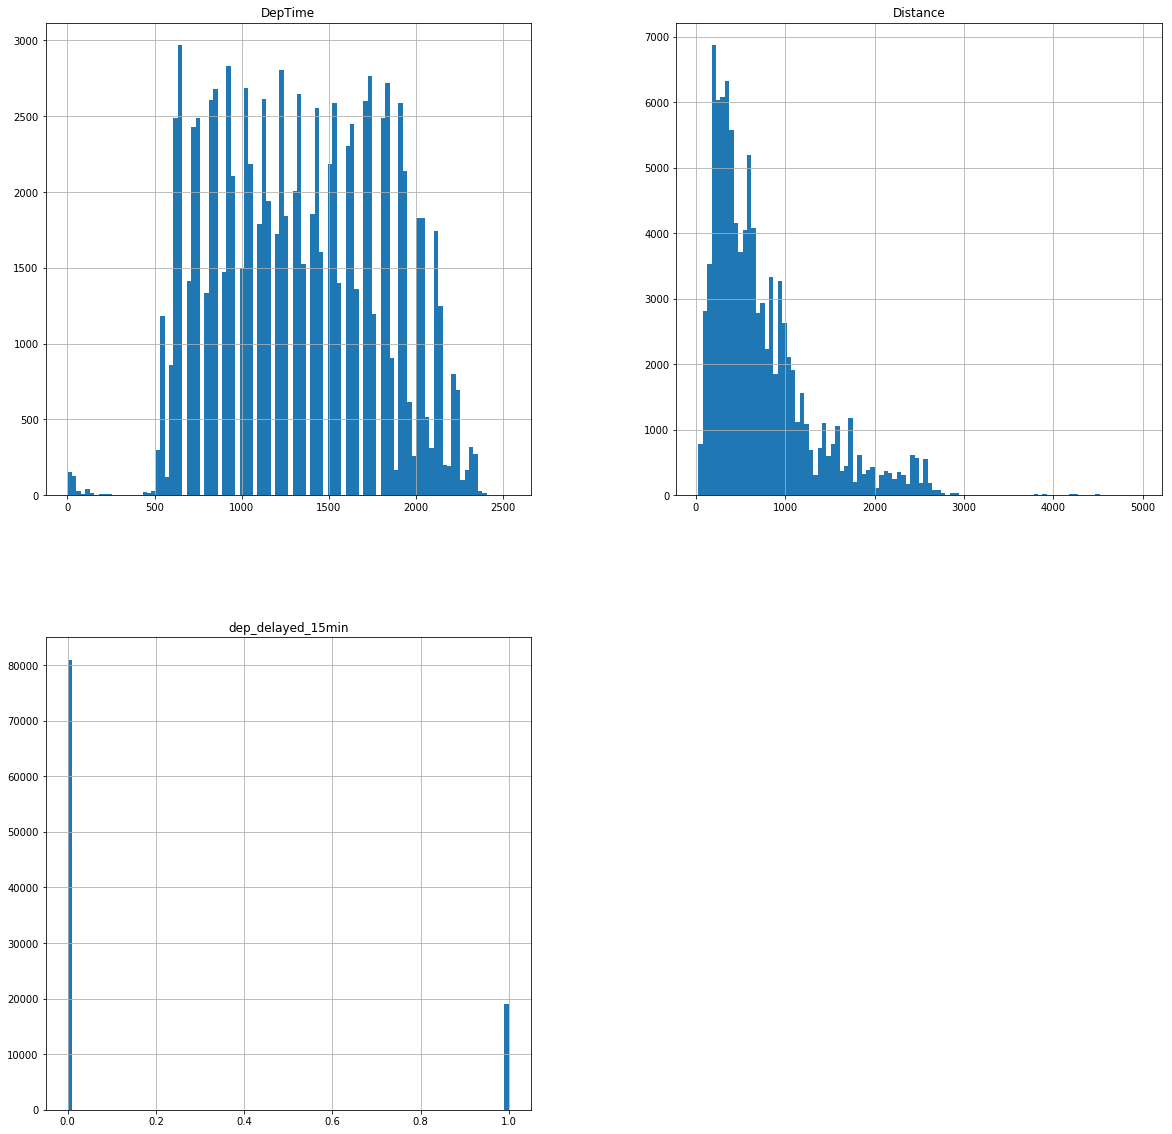

In [304]:
# Посмотрим на распределение признаков
train_df_fd.hist(figsize=(20,20), bins=100);

Искать аномалии можно, анализируя непараметрически восстановленную плотность одномерного распределения. Так можно заметить, что какие-то объекты выбиваются из общей тенденции.

В seaborn это удобно делать с помощью метода distplot. 

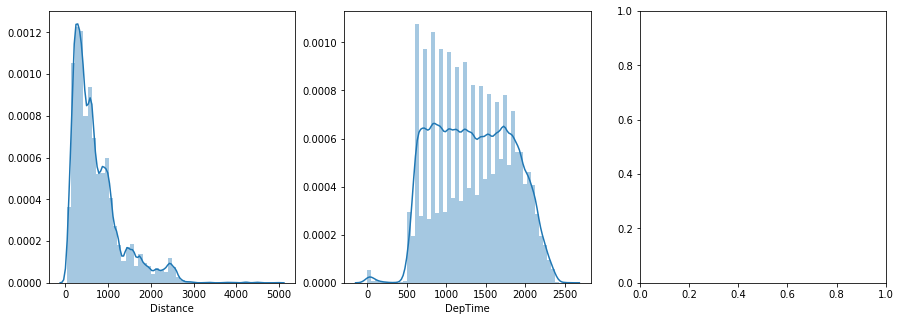

In [84]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, col in enumerate(['Distance', 'DepTime']):
    sns.distplot(train_df_fd[col].dropna(), bins=50, ax=axes[i])
pass

Посмотрим на попарные корреляции вещественных признаков и целевой метки:

In [302]:
train_df_fd.corr()

,DepTime,Distance,dep_delayed_15min
DepTime,1.000000,-0.020681,0.243819
Distance,-0.020681,1.000000,-0.002734
dep_delayed_15min,0.243819,-0.002734,1.000000


Посмотрим на пэирплоты признаков. По диагонали можно увидеть кривые распределений значений целевой метки.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning:

invalid value encountered in true_divide

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning:

invalid value encountered in double_scalars



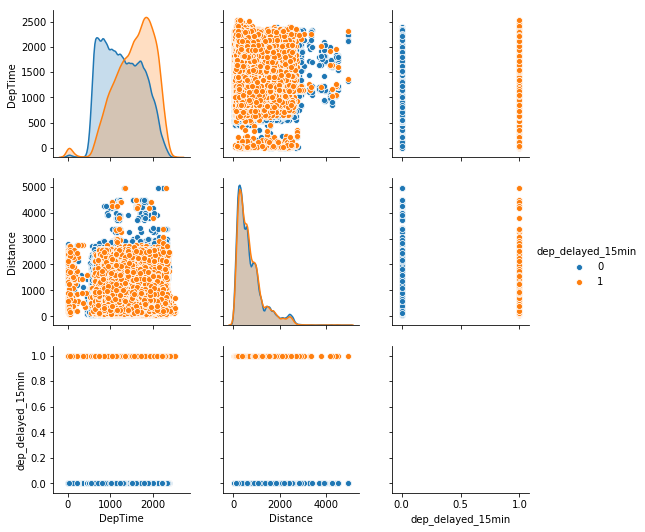

In [303]:
sns.pairplot(train_df_fd, hue="dep_delayed_15min");

Как по числовым значениям, так и по кривым наблюдается корреляция целевой метки с 'DepTime'

In [122]:
columns_enc_1 = ['Month', 'DayofMonth', 'DayOfWeek']
columns_enc_2 = ['UniqueCarrier']

In [363]:
train_df_fd_enc = pd.get_dummies(train_df_fd, columns=columns_enc_1)
corr = train_df_fd_enc.drop('dep_delayed_15min', axis=1).corrwith(
                    train_df_fd['dep_delayed_15min'], 
                    axis=0, drop=False, method='pearson'
                    )
corr.sort_values(ascending=False)[:6]

DepTime            0.243819
Month_c-12         0.038848
Month_c-7          0.037493
DayOfWeek_c-5      0.035553
Month_c-6          0.024279
DayofMonth_c-22    0.023056
dtype: float64

In [364]:
train_df_fd_enc = pd.get_dummies(train_df_fd, columns=columns_enc_2)
corr = train_df_fd_enc.drop('dep_delayed_15min', axis=1).corrwith(
                    train_df_fd['dep_delayed_15min'], 
                    axis=0, drop=False, method='pearson'
                    )
corr.sort_values(ascending=False)[:6]

DepTime             0.243819
UniqueCarrier_EV    0.043721
UniqueCarrier_WN    0.024679
UniqueCarrier_FL    0.023331
UniqueCarrier_AS    0.020361
UniqueCarrier_YV    0.012837
dtype: float64

<a id='2part'></a>
## Дальнейшее исследование, добавление признаков

[Первичный анализ](#1part)

[Дальнейшее исследование, добавление признаков](#2part)

[Быстрый вызов](#3part)

Посмотрим на распределение задерживающихся рейсов во времени дня. 

Также нужно учитывать, что на графике такого распределеня будет сложно увидеть пропорциональное изменение задерживающихся рейсов, поэтому помимно него информативно будет смотреть на соотношение опоздавших рейсов к их общему количеству в зависимости от времени. 

Разделим DepTime на интервалы (добавим соответствующий признак в наш DataFrame) и посмотрим соотношения меток на каждом из них:

In [118]:
train_df_fd['DepTime_cat'] = np.floor(train_df_fd.DepTime / 100).astype('int')
test_df_fd['DepTime_cat'] = np.floor(test_df_fd.DepTime / 100).astype('int')

# train_df_fd['DepTime_cat'] = np.floor(train_df_fd.DepTime / 80).astype('int')
# test_df_fd['DepTime_cat'] = np.floor(test_df_fd.DepTime / 80).astype('int')

print('Интеровалов: ' 
      + str(len(test_df_fd['DepTime_cat'].value_counts()) - 1))

Интеровалов: 24


In [197]:
DepTime_cat_cross_tab = pd.crosstab(train_df_fd['DepTime_cat'], train_df_fd.dep_delayed_15min)

AttributeError: 'DataFrame' object has no attribute 'dep_delayed_15min'

In [120]:
trace0 = go.Scatter(
    x = DepTime_cat_cross_tab.index,
    y = DepTime_cat_cross_tab[0],
    mode = 'lines+markers',
    name = 'No Delay'
)
trace1 = go.Scatter(
    x = DepTime_cat_cross_tab.index,
    y = DepTime_cat_cross_tab[1],
    #mode = 'markers',
    mode = 'lines+markers',
    name = 'Delays'
)
data = [trace0, trace1]
layout = go.Layout(title="Amount of delays according to DepTime")

fig = go.Figure(data=data, layout=layout)
# fig.show()

iplot(fig)

In [121]:
trace0 = go.Scatter(
    x = DepTime_cat_cross_tab.index,
    y = DepTime_cat_cross_tab[1] / (DepTime_cat_cross_tab[0]+DepTime_cat_cross_tab[1]),
    mode = 'lines+markers',
    name = 'No Delay',
)
trace1 = go.Scatter(
    x = DepTime_cat_cross_tab.index,
    y = DepTime_cat_cross_tab[1],
#     mode = 'markers',
    mode = 'lines+markers',
    name = 'Delays'
)
data = [trace0]
layout = go.Layout(title="Delay ratio according to DepTime")

fig = go.Figure(data=data, layout=layout)
# fig.show()

iplot(fig)

До интервала 5 смотреть на распределение не корректо, так как в нем слишком мало наблюдений, после же наблюдается постепенное увеличение количества опаздывающих рейсов. После интервала 23 снова слишком мало наблюдений.

Оставим только наблюдения, входящие во временной интервал (4:24):

In [638]:
train_df_fd = train_df_fd[(train_df_fd['DepTime_cat'] > 4) & (train_df_fd['DepTime_cat'] < 24)]

# train_df_fd = train_df_fd[(train_df_fd['DepTime_cat'] > 5) & (train_df_fd['DepTime_cat'] < 30)]

# train_df_fd['DepTime_cat'].replace([0, 1, 2, 3, 4], 5, inplace=True)
# train_df_fd['DepTime_cat'].replace([24, 25], 23, inplace=True)

In [332]:
train_df_fd['Dep_hour_flag'] = ((train_df_fd['DepTime_cat'] >= 6) & (train_df_fd['DepTime_cat'] < 23)).astype('int')

Поработаем с признаком Distance.

Разделим на интервалы, посмотрим графики распределений меток и их долей.

In [127]:
train_df_fd['distance_cat'] = np.floor(train_df_fd.Distance / 200).astype('int')
test_df_fd['distance_cat'] = np.floor(test_df_fd.Distance / 200).astype('int')

# train_df_fd['distance_cat'] = np.floor(train_df_fd.Distance / 100).astype('int')
# test_df_fd['distance_cat'] = np.floor(test_df_fd.Distance / 100).astype('int')


print(len(train_df_fd['distance_cat'].value_counts()))

24


In [128]:
distance_cat_cross_tab = pd.crosstab(train_df_fd['distance_cat'], train_df_fd.dep_delayed_15min)

In [129]:
trace0 = go.Scatter(
    x = distance_cat_cross_tab.index,
    y = distance_cat_cross_tab[0],
    mode = 'lines+markers',
    name = 'No Delay'
)
trace1 = go.Scatter(
    x = distance_cat_cross_tab.index,
    y = distance_cat_cross_tab[1],
    #mode = 'markers',
    mode = 'lines+markers',
    name = 'Delays'
)
data = [trace0, trace1]
layout = go.Layout(title="Amount of delays according to distance")

fig = go.Figure(data=data, layout=layout)
# fig.show()

iplot(fig)

In [130]:
trace0 = go.Scatter(
    x = distance_cat_cross_tab.index,
    y = distance_cat_cross_tab[1] / (distance_cat_cross_tab[0]+distance_cat_cross_tab[1]),
    mode = 'lines+markers',
    name = 'No Delay'
)
trace1 = go.Scatter(
    x = distance_cat_cross_tab.index,
    y = distance_cat_cross_tab[1] / (distance_cat_cross_tab[0]+distance_cat_cross_tab[1]),
    #mode = 'markers',
    mode = 'lines+markers',
    name = 'Delays'
)
data = [trace0]
layout = go.Layout(title="Delay ratio according to distance")

fig = go.Figure(data=data, layout=layout)
# fig.show()

iplot(fig)

На графиках видна динамика - признак будет описывать изменение целевой метки, однако на дистанциях интервала >5 недостаточно данных, поэтому участок после 5 имеет резкие необоснованные скачки.
Удалим семплы с дистанциями на интервале >5 (всего около 150):

In [131]:
# train_df_fd = train_df_fd[train_df_fd['distance_cat'] < 28]
test_df_fd = test_df_fd[test_df_fd['distance_cat'] < 15]

Поработаем с годовыми кварталами

In [132]:
train_df_fd['Quarters'] = (np.ceil(train_df_fd.Month / 3)).astype('int')
test_df_fd['Quarters'] = (np.ceil(test_df_fd.Month / 3)).astype('int')

In [133]:
quarters_cross_tab = pd.crosstab(train_df_fd['Quarters'], train_df_fd.dep_delayed_15min)
quarters_cross_tab

dep_delayed_15min,0,1
Quarters,,
1,19557,4531
2,20879,4486
3,20564,5135
4,19956,4892


In [134]:
trace0 = go.Scatter(
    x = quarters_cross_tab.index,
    y = quarters_cross_tab[0],
    mode = 'lines+markers',
    name = 'No Delay'
)
trace1 = go.Scatter(
    x = quarters_cross_tab.index,
    y = quarters_cross_tab[1],
    #mode = 'markers',
    mode = 'lines+markers',
    name = 'Delays'
)
data = [trace0, trace1]
layout = go.Layout(title="Amount of delays according to year's quarter")

fig = go.Figure(data=data, layout=layout)
# fig.show()

iplot(fig)

In [135]:
trace0 = go.Scatter(
    x = quarters_cross_tab.index,
    y = quarters_cross_tab[1] / (quarters_cross_tab[0] + quarters_cross_tab[1]),
    mode = 'lines+markers',
    name = 'No Delay'
)
trace1 = go.Scatter(
    x = quarters_cross_tab.index,
    y = quarters_cross_tab[1],
    #mode = 'markers',
    mode = 'lines+markers',
    name = 'Delays'
)
data = [trace0]
layout = go.Layout(title="Delay ratio according to year's quarter")

fig = go.Figure(data=data, layout=layout)
# fig.show()

iplot(fig)

---

In [136]:
pd.crosstab(train_df_fd['Distance > 1000'], train_df_fd.dep_delayed_15min)

KeyError: 'Distance > 1000'

In [137]:
train_df_fd['Distance > 1000'] = train_df_fd['Distance'].apply(lambda x: 0 if x < 1000 else 1)
test_df_fd['Distance > 1000'] = test_df_fd['Distance'].apply(lambda x: 0 if x < 1000 else 1)

In [138]:
df_t = pd.crosstab(train_df_fd.Dep_hour,train_df_fd.dep_delayed_15min)
df_t.head()

AttributeError: 'DataFrame' object has no attribute 'Dep_hour'

Исследуем влияние месяцев:

In [139]:
month_cross_tab = pd.crosstab(train_df_fd['Month'], train_df_fd.dep_delayed_15min)

In [140]:
trace0 = go.Scatter(
    x = month_cross_tab.index,
    y = month_cross_tab[0],
    mode = 'lines+markers',
    name = 'No Delay'
)
trace1 = go.Scatter(
    x = month_cross_tab.index,
    y = month_cross_tab[1],
    #mode = 'markers',
    mode = 'lines+markers',
    name = 'Delays'
)
data = [trace0, trace1]
layout = go.Layout(title="Amount of delays according to month")

fig = go.Figure(data=data, layout=layout)
# fig.show()

iplot(fig)

In [141]:
trace0 = go.Scatter(
    x = month_cross_tab.index,
    y = month_cross_tab[1] / (month_cross_tab[0]+month_cross_tab[1]),
    mode = 'lines+markers',
    name = 'No Delay'
)
trace1 = go.Scatter(
    x = month_cross_tab.index,
    y = month_cross_tab[1],
    #mode = 'markers',
    mode = 'lines+markers',
    name = 'Delays'
)
data = [trace0]
layout = go.Layout(title="Delay ratio according to month")

fig = go.Figure(data=data, layout=layout)
# fig.show()

iplot(fig)

Добавим маркер для месяцев в интервале [6, 7]:

In [641]:
train_df_fd['Months [6,7]'] = train_df_fd['Month'].apply(lambda x: 1 if x >= 6 and x <= 7 else 0)
test_df_fd['Months [6,7]'] = test_df_fd['Month'].apply(lambda x: 1 if x >= 6 and x <= 7 else 0)

In [176]:
depmin_cross_tab = pd.crosstab(test_df_fd['Dep_minute'], train_df_fd.dep_delayed_15min)

In [177]:
trace0 = go.Scatter(
    x = depmin_cross_tab.index,
    y = depmin_cross_tab[0],
    mode = 'lines+markers',
    name = 'No Delay'
)
trace1 = go.Scatter(
    x = depmin_cross_tab.index,
    y = depmin_cross_tab[1],
    #mode = 'markers',
    mode = 'lines+markers',
    name = 'Delays'
)
data = [trace0, trace1]
layout = go.Layout(title="Amount of delays according to depmin")

fig = go.Figure(data=data, layout=layout)
# fig.show()

iplot(fig)

In [180]:
trace0 = go.Scatter(
    x = depmin_cross_tab.index,
    y = depmin_cross_tab[1] / (depmin_cross_tab[0]+depmin_cross_tab[1]),
    mode = 'lines+markers',
    name = 'No Delay'
)
trace1 = go.Scatter(
    x = depmin_cross_tab.index,
    y = depmin_cross_tab[1],
    #mode = 'markers',
    mode = 'lines+markers',
    name = 'Delays'
)
data = [trace0]
layout = go.Layout(title="Delay ratio according to depmin")

fig = go.Figure(data=data, layout=layout)
# fig.show()

iplot(fig)

Исследуем влияние дней в месяце:

In [142]:
dayofmonth_cross_tab = pd.crosstab(train_df_fd['DayofMonth'], train_df_fd.dep_delayed_15min)

# dayofmonth_cross_tab = pd.crosstab(np.ceil(test_df_fd['DayofMonth'] / 5), 
#                                    train_df_fd.dep_delayed_15min)

In [143]:
trace0 = go.Scatter(
    x = dayofmonth_cross_tab.index,
    y = dayofmonth_cross_tab[0],
    mode = 'lines+markers',
    name = 'No Delay'
)
trace1 = go.Scatter(
    x = dayofmonth_cross_tab.index,
    y = dayofmonth_cross_tab[1],
    #mode = 'markers',
    mode = 'lines+markers',
    name = 'Delays'
)
data = [trace0, trace1]
layout = go.Layout(title="Amount of delays according to day in month")

fig = go.Figure(data=data, layout=layout)
# fig.show()

iplot(fig)

In [144]:
trace0 = go.Scatter(
    x = dayofmonth_cross_tab.index,
    y = dayofmonth_cross_tab[1] / (dayofmonth_cross_tab[1] + dayofmonth_cross_tab[0]),
    mode = 'lines+markers',
    name = 'No Delay'
)
trace1 = go.Scatter(
    x = dayofmonth_cross_tab.index,
    y = dayofmonth_cross_tab[1],
    #mode = 'markers',
    mode = 'lines+markers',
    name = 'Delays'
)
data = [trace0]
layout = go.Layout(title="Delay ratio according to day in month")

fig = go.Figure(data=data, layout=layout)
# fig.show()

iplot(fig)

Поисследуем распределение опозданий по дням в конкретных месяцах

In [148]:
dayofmonth_cross_tab = pd.crosstab \
        (train_df_fd['DayofMonth'][train_df_fd['Month'] == 12], train_df_fd.dep_delayed_15min)

In [149]:
trace0 = go.Scatter(
    x = dayofmonth_cross_tab.index,
    y = dayofmonth_cross_tab[0],
    mode = 'lines+markers',
    name = 'No Delay'
)
trace1 = go.Scatter(
    x = dayofmonth_cross_tab.index,
    y = dayofmonth_cross_tab[1],
    #mode = 'markers',
    mode = 'lines+markers',
    name = 'Delays'
)
data = [trace0, trace1]
layout = go.Layout(title="Amount of delays according to day in particular month")

fig = go.Figure(data=data, layout=layout)
# fig.show()

iplot(fig)

In [150]:
trace0 = go.Scatter(
    x = dayofmonth_cross_tab.index,
    y = dayofmonth_cross_tab[1] / (dayofmonth_cross_tab[1] + dayofmonth_cross_tab[0]),
    mode = 'lines+markers',
    name = 'No Delay'
)
trace1 = go.Scatter(
    x = dayofmonth_cross_tab.index,
    y = dayofmonth_cross_tab[1],
    #mode = 'markers',
    mode = 'lines+markers',
    name = 'Delays'
)
data = [trace0]
layout = go.Layout(title="Delay ratio according to day in particular month")

fig = go.Figure(data=data, layout=layout)
# fig.show()

iplot(fig)

Добавим флаг:

In [153]:
train_df_fd['DayofMonth_flag_12_25'].shape

(100000,)

In [152]:
train_df_fd['DayofMonth_flag_12_25'] = ((train_df_fd['DayofMonth'] == 25) \
                                   & (train_df_fd['Month'] == 12)).astype('int')

Исследуем влияние дней в неделе. Отдельно посмотрим на долю опаздавших рейсов на тестовой и обучающей выборках.

In [762]:
dayofweek_cross_tab = pd.crosstab(train_df_fd['DayOfWeek'], train_df_fd.dep_delayed_15min)

dayofweek_cross_tab_test = pd.crosstab(test_df_fd['DayOfWeek'], train_df_fd.dep_delayed_15min)

In [760]:
trace0 = go.Scatter(
    x = dayofweek_cross_tab.index,
    y = dayofweek_cross_tab[0],
    mode = 'lines+markers',
    name = 'No Delay'
)
trace1 = go.Scatter(
    x = dayofweek_cross_tab.index,
    y = dayofweek_cross_tab[1],
    #mode = 'markers',
    mode = 'lines+markers',
    name = 'Delays'
)
data = [trace0, trace1]
layout = go.Layout(title="Amount of delays according to day of week")

fig = go.Figure(data=data, layout=layout)
# fig.show()

iplot(fig)

In [763]:
trace0 = go.Scatter(
    x = dayofweek_cross_tab.index,
    y = dayofweek_cross_tab[1] / (dayofweek_cross_tab[0]+dayofweek_cross_tab[1]),
    mode = 'lines+markers',
    name = 'No Delay'
)
trace1 = go.Scatter(
    x = dayofweek_cross_tab.index,
    y = dayofweek_cross_tab[1],
    #mode = 'markers',
    mode = 'lines+markers',
    name = 'Delays'
)
data = [trace0]
layout = go.Layout(title="Delay ratio according to day of week")

fig = go.Figure(data=data, layout=layout)
# fig.show()

iplot(fig)

In [767]:
trace0 = go.Scatter(
    x = dayofweek_cross_tab.index,
    y = dayofweek_cross_tab[1] / (dayofweek_cross_tab[0]+dayofweek_cross_tab[1]),
    mode = 'lines+markers',
    name = 'No Delay'
)
trace1 = go.Scatter(
    x = dayofweek_cross_tab.index,
    y = dayofweek_cross_tab[1],
    #mode = 'markers',
    mode = 'lines+markers',
    name = 'Delays'
)
data = [trace0]
layout = go.Layout(title="Delay ratio according to day of week for train sample")

fig = go.Figure(data=data, layout=layout)
# fig.show()

iplot(fig)

In [766]:
trace0 = go.Scatter(
    x = dayofweek_cross_tab_test.index,
    y = dayofweek_cross_tab_test[1] / (dayofweek_cross_tab_test[0]+dayofweek_cross_tab_test[1]),
    mode = 'lines+markers',
    name = 'No Delay'
)
trace1 = go.Scatter(
    x = dayofweek_cross_tab.index,
    y = dayofweek_cross_tab[1],
    #mode = 'markers',
    mode = 'lines+markers',
    name = 'Delays'
)
data = [trace0]
layout = go.Layout(title="Delay ratio according to day of week for test sample")

fig = go.Figure(data=data, layout=layout)
# fig.show()

iplot(fig)

Не наблюдается констинтетной зависимости.

Исследуем опоздания в зависимости от компании-перевозчика

In [782]:
trace1 = go.Bar(
            x = train_df_fd[train_df_fd['dep_delayed_15min'] == 1]['UniqueCarrier'].value_counts().index.values,
            y = train_df_fd[train_df_fd['dep_delayed_15min'] == 1]['UniqueCarrier'].value_counts().values,
            name='Yes',
            #marker=dict(color='rgb(49,130,189)')
            marker=dict(color='red',opacity=0.6)
)
trace2 = go.Bar(
            x = train_df_fd[train_df_fd['dep_delayed_15min'] == 0]['UniqueCarrier'].value_counts().index.values,
            y = train_df_fd[train_df_fd['dep_delayed_15min'] == 0]['UniqueCarrier'].value_counts().values,
            name='No',
            marker=dict(color='grey',opacity=0.8)
)

data = [trace1, trace2]
    
layout = go.Layout(title="Carrier wise flight distribution by Delay",
    xaxis=dict(title='Unique Carrier',tickangle=-45),
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [812]:
((train_df_fd[train_df_fd['dep_delayed_15min'] == 1]['UniqueCarrier'].value_counts().values) \
        /train_df_fd[train_df_fd['dep_delayed_15min'] == 0]['UniqueCarrier'].value_counts()).sort_values().values

array([0.08333333, 0.08638743, 0.0877915 , 0.16582064, 0.18352941,
       0.19259259, 0.20103761, 0.20307808, 0.21435973, 0.22051282,
       0.2205171 , 0.2246033 , 0.22786238, 0.22992438, 0.23143305,
       0.27099842, 0.27134789, 0.27197232, 0.27668539, 0.28969697,
       0.31958315, 0.32183224])

In [821]:
((train_df_fd[train_df_fd['dep_delayed_15min'] == 1]['UniqueCarrier'].value_counts().values) \
                 /train_df_fd[train_df_fd['dep_delayed_15min'] == 0]['UniqueCarrier'].value_counts()).sort_values().index

Index(['AQ', 'TZ', 'HA', 'HP', 'F9', 'DH', 'US', 'NW', 'DL', 'XE', 'MQ', 'OO',
       'CO', 'UA', 'AA', 'OH', 'WN', 'B6', 'EV', 'YV', 'FL', 'AS'],
      dtype='object')

In [822]:
trace1 = go.Bar(
    x = ((train_df_fd[train_df_fd['dep_delayed_15min'] == 1]['UniqueCarrier'].value_counts().values) \
                 /train_df_fd[train_df_fd['dep_delayed_15min'] == 0]['UniqueCarrier'].value_counts()).sort_values().index,
    y = ((train_df_fd[train_df_fd['dep_delayed_15min'] == 1]['UniqueCarrier'].value_counts().values) \
        /train_df_fd[train_df_fd['dep_delayed_15min'] == 0]['UniqueCarrier'].value_counts()).sort_values().values,
            name='Yes',
            #marker=dict(color='rgb(49,130,189)')
            marker=dict(color='red',opacity=0.6)
)
trace2 = go.Bar(
            x = train_df_fd[train_df_fd['dep_delayed_15min'] == 0]['UniqueCarrier'].value_counts().index.values,
            y = train_df_fd[train_df_fd['dep_delayed_15min'] == 0]['UniqueCarrier'].value_counts().values,
            name='No',
            marker=dict(color='grey',opacity=0.8)
)

data = [trace1,]
    
layout = go.Layout(title="Carrier wise flight distribution by Delay",
    xaxis=dict(title='Unique Carrier',tickangle=-45),
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [833]:
((train_df_fd[train_df_fd['dep_delayed_15min'] == 1]['UniqueCarrier'].value_counts().values) \
                 /train_df_fd[train_df_fd['dep_delayed_15min'] == 0]['UniqueCarrier'].value_counts()).sort_values().index

Index(['AQ', 'TZ', 'HA', 'HP', 'F9', 'DH', 'US', 'NW', 'DL', 'XE', 'MQ', 'OO',
       'CO', 'UA', 'AA', 'OH', 'WN', 'B6', 'EV', 'YV', 'FL', 'AS'],
      dtype='object')

In [835]:
train_df_fd['UniqueCarrier'].replace(['AQ', 'TZ', 'HA'], 1, inplace=True)
train_df_fd['UniqueCarrier'].replace(['HP', 'F9', 'DH', 'US', 'NW'], 2, inplace=True)
train_df_fd['UniqueCarrier'].replace(['DL', 'XE', 'MQ', 'OO','CO', 'UA', 'AA'], 3, inplace=True)
train_df_fd['UniqueCarrier'].replace(['OH', 'WN', 'B6', 'EV', 'YV'], 4, inplace=True)
train_df_fd['UniqueCarrier'].replace(['FL', 'AS'], 5, inplace=True)

In [642]:
# Добавим еще признаков
train_df_fd['Dep_minute'] =  train_df_fd['DepTime']%100
test_df_fd['Dep_minute'] =  test_df_fd['DepTime']%100

train_df_fd['DepTimeLog'] = train_df_fd['DepTime'].apply(lambda x: np.log(x))
test_df_fd['DepTimeLog'] = test_df_fd['DepTime'].apply(lambda x: np.log(x))
train_df_fd['DepTimepairs'] = train_df_fd['DepTime'] * np.append(train_df_fd['DepTime'][1:], 1)
test_df_fd['DepTimepairs'] = test_df_fd['DepTime'] * np.append(test_df_fd['DepTime'][1:], 1)
train_df_fd['DepTimesqrt'] = train_df_fd['DepTime'].apply(lambda x: np.sqrt(x))
test_df_fd['DepTimesqrt'] = test_df_fd['DepTime'].apply(lambda x: np.sqrt(x))

In [643]:
y_train = train_df_fd['dep_delayed_15min']
train_df_fd = train_df_fd.drop('dep_delayed_15min', axis=1)

In [649]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(train_df_fd, y_train, 
                                                                test_size=0.3, 
                                                                random_state=17)
len(X_train_part.columns), X_train_part.columns, np.append(categ_feat_idx, [9,10,11])

(17, Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier',
        'Origin', 'Dest', 'Distance', 'flight', 'DepTime_cat', 'distance_cat',
        'Months [6,7]', 'Dep_minute', 'DepTimeLog', 'DepTimepairs',
        'DepTimesqrt', 'DayofMonth/5'],
       dtype='object'), array([ 0,  1,  2,  4,  5,  6,  8,  9, 10, 11], dtype=int64))

In [647]:
# %%time
# Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier',
#         'Origin', 'Dest', 'Distance', 'flight', 'DepTime_cat', 'distance_cat',
#         'Months [6,7]', 'Dep_minute', 'DepTimeLog', 'DepTimepairs',
#         'DepTimesqrt'])
ctb = CatBoostClassifier(random_seed=17, eval_metric = 'AUC')
ctb.fit(X_train_part, y_train_part,
        eval_set=(X_valid, y_valid),
        cat_features=np.append(categ_feat_idx, [9, 10]),
        early_stopping_rounds = 500,
        verbose = 200,
        use_best_model=True,
        plot=False,
    
       );

Learning rate set to 0.121809
0:	test: 0.6805686	best: 0.6805686 (0)	total: 159ms	remaining: 2m 39s
200:	test: 0.7860551	best: 0.7860562 (199)	total: 34.3s	remaining: 2m 16s
400:	test: 0.7989545	best: 0.7989545 (400)	total: 1m 7s	remaining: 1m 41s
600:	test: 0.8020117	best: 0.8023860 (554)	total: 1m 47s	remaining: 1m 11s
800:	test: 0.8054762	best: 0.8055598 (796)	total: 2m 20s	remaining: 35s
999:	test: 0.8078700	best: 0.8079154 (993)	total: 2m 54s	remaining: 0us

bestTest = 0.8079153852
bestIteration = 993

Shrink model to first 994 iterations.


In [432]:
# %%time
ctb = CatBoostClassifier(random_seed=17, eval_metric = 'AUC')
ctb.fit(X_train_part, y_train_part,
        eval_set=(X_valid, y_valid),
        cat_features=np.append(categ_feat_idx, [9, 10, 11]),
        early_stopping_rounds = 500,
        verbose = 200,
        use_best_model=True,
        plot=False,
    
       );

Learning rate set to 0.121809
0:	test: 0.6656585	best: 0.6656585 (0)	total: 78.1ms	remaining: 1m 18s
200:	test: 0.7773714	best: 0.7773714 (200)	total: 40.6s	remaining: 2m 41s
400:	test: 0.7836897	best: 0.7837664 (396)	total: 1m 24s	remaining: 2m 5s
600:	test: 0.7855709	best: 0.7855781 (599)	total: 2m 7s	remaining: 1m 24s
800:	test: 0.7869671	best: 0.7869671 (800)	total: 2m 52s	remaining: 42.9s
999:	test: 0.7877893	best: 0.7879423 (949)	total: 3m 30s	remaining: 0us

bestTest = 0.7879422963
bestIteration = 949

Shrink model to first 950 iterations.


In [408]:
# %%time
ctb = CatBoostClassifier(random_seed=17, eval_metric = 'AUC')
ctb.fit(X_train_part, y_train_part,
        eval_set=(X_valid, y_valid),
        cat_features=np.append(categ_feat_idx, [9, 10, 11]),
        early_stopping_rounds = 500,
        verbose = 200,
        use_best_model=True,
        plot=False,
    
       );

Learning rate set to 0.121809
0:	test: 0.6656585	best: 0.6656585 (0)	total: 76.8ms	remaining: 1m 16s
200:	test: 0.7773714	best: 0.7773714 (200)	total: 41.3s	remaining: 2m 44s
400:	test: 0.7836897	best: 0.7837664 (396)	total: 1m 25s	remaining: 2m 8s
600:	test: 0.7855709	best: 0.7855781 (599)	total: 2m 9s	remaining: 1m 26s
800:	test: 0.7869671	best: 0.7869671 (800)	total: 2m 51s	remaining: 42.6s
999:	test: 0.7877893	best: 0.7879423 (949)	total: 3m 31s	remaining: 0us

bestTest = 0.7879422963
bestIteration = 949

Shrink model to first 950 iterations.


In [389]:
# %%time
ctb = CatBoostClassifier(random_seed=17, eval_metric = 'AUC')
ctb.fit(X_train_part, y_train_part,
        eval_set=(X_valid, y_valid),
        cat_features=np.append(categ_feat_idx, [9, 10, 11]),
        early_stopping_rounds = 500,
        verbose = 200,
        use_best_model=True,
        plot=False,
    
       );

Learning rate set to 0.121809
0:	test: 0.6670221	best: 0.6670221 (0)	total: 85ms	remaining: 1m 24s
200:	test: 0.7771619	best: 0.7771712 (199)	total: 44.9s	remaining: 2m 58s
400:	test: 0.7818887	best: 0.7818887 (400)	total: 1m 29s	remaining: 2m 14s
600:	test: 0.7832598	best: 0.7835761 (566)	total: 2m 14s	remaining: 1m 29s
800:	test: 0.7841963	best: 0.7842152 (796)	total: 3m 1s	remaining: 45.2s
999:	test: 0.7855865	best: 0.7856162 (989)	total: 3m 43s	remaining: 0us

bestTest = 0.7856162485
bestIteration = 989

Shrink model to first 990 iterations.


In [434]:
params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose': 200,
          'random_seed': 17
         }
all_train_data = Pool(data=train_df_fd,
                      label=y_train,
                      cat_features=np.append(categ_feat_idx, [9,10,11])
                     )
scores = cv(pool=all_train_data,
            params=params, 
            fold_count=3,
            seed=17, 
            shuffle=True,
            stratified=True, # if True the folds are made by preserving the percentage of samples for each class
            plot=True
           )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6725271	best: 0.6725271 (0)	total: 829ms	remaining: 13m 48s
200:	test: 0.7584550	best: 0.7584550 (200)	total: 3m 21s	remaining: 13m 22s
400:	test: 0.7681413	best: 0.7681413 (400)	total: 6m 22s	remaining: 9m 31s
600:	test: 0.7741744	best: 0.7741744 (600)	total: 9m 55s	remaining: 6m 35s
800:	test: 0.7767878	best: 0.7767887 (799)	total: 13m 30s	remaining: 3m 21s
999:	test: 0.7786632	best: 0.7786632 (999)	total: 17m 13s	remaining: 0us


In [491]:
len(train_df_fd.columns), train_df_fd.columns

(15, Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier',
        'Origin', 'Dest', 'Distance', 'flight', 'DepTime_cat', 'distance_cat',
        'Dep_minute', 'DepTimeLog', 'DepTimepairs', 'DepTimesqrt'],
       dtype='object'))

In [487]:
# %%time
# ctb = CatBoostClassifier(random_seed=17, eval_metric = 'AUC', iterations=949,
#                         learning_rate=0.121809)
ctb.fit(train_df_fd, y_train,
        cat_features=np.append(categ_feat_idx, [9, 10, 11]),
        early_stopping_rounds = 200,
        verbose = 200
       );

Learning rate set to 0.06156
0:	total: 164ms	remaining: 2m 43s
200:	total: 44.3s	remaining: 2m 56s
400:	total: 1m 29s	remaining: 2m 14s
600:	total: 2m 19s	remaining: 1m 32s
800:	total: 3m 8s	remaining: 46.9s
999:	total: 3m 55s	remaining: 0us


In [488]:
ctb_test_pred2 = ctb.predict_proba(test_df_fd)[:, 1]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    sample_sub = pd.read_csv('sample_submission.csv', 
                             index_col='id')
    sample_sub['dep_delayed_15min'] = ctb_test_pred2
    sample_sub.to_csv('ctb_pred3.csv')

In [ ]:
# Попробуем SGD:

train_df_fd_dum = pd.get_dummies(train_df_fd, columns=[X_train_part.columns[i] for i in \
                                                       np.append(categ_feat_idx, [9,10,11])])

X_train_part_sgd, X_valid_sgd, y_train_part_sgd, y_valid_sgd = train_test_split(train_df_fd_dum, 
                                                                                y_train, 
                                                                                test_size=0.3, 
                                                                                random_state=17)


sgd_logit_mini = SGDClassifier(loss='log', random_state=17, n_jobs=-1, tol=1e-3, max_iter=1000,
                              n_iter_no_change=200)
sgd_logit_mini.fit(X_train_part_sgd, y_train_part_sgd)
logit_valid_pred_proba = sgd_logit_mini.predict_proba(X_valid_sgd)
round(roc_auc_score(y_valid_sgd, logit_valid_pred_proba[:, 1]), 3)

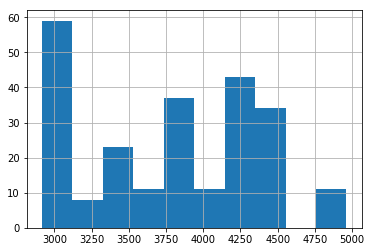

In [199]:
train_df_fd['Distance'][train_df_fd['Distance'] > 2900].hist();

In [196]:
test_df_fd['DepTime'][test_df_fd['DepTime'] <= 330].shape

(446,)

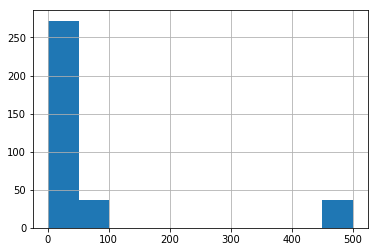

In [256]:
train_df_fd['DepTime'][(train_df_fd['DepTime'] >= 450) | (train_df_fd['DepTime'] <= 80)][train_df_fd['DepTime'] <= 500].hist()

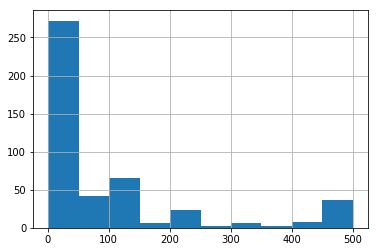

In [251]:
train_df_fd['DepTime'][(train_df_fd['DepTime'] <= 500)].hist();
# w[train_df_fd['DepTime'] < 500].hist()

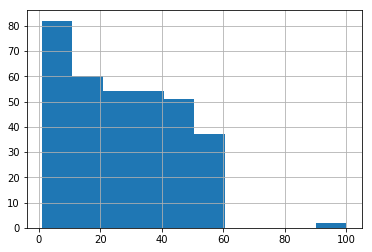

In [225]:
test_df_fd['DepTime'][test_df_fd['DepTime'] <= 00].hist()

In [ ]:
train_df_fd = train_df_fd[train_df_fd['DepTimeLog'] > 6.3]

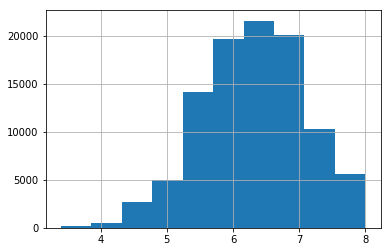

In [497]:
train_df_fd['Distance'] = np.log(train_df_fd['Distance'])
train_df_fd = train_df_fd[(train_df_fd['Distance'] > 3.8) & (train_df_fd['Distance'] < 8)]
train_df_fd['Distance'].hist()

<a id='3part'></a>
## Быстрый вызов:

[Первичный анализ](#1part)

[Дальнейшее исследование, добавление признаков](#2part)

[Быстрый вызов](#3part)

Подготовка выборки

In [ ]:
train_df_fd['']

In [533]:
train_df_fd.dtypes

Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime                int64
UniqueCarrier         object
Origin                object
Dest                  object
Distance             float64
dep_delayed_15min      int64
flight                object
DepTime_cat            int32
distance_cat           int32
Months [6,7,12]        int64
Dep_minute             int64
DepTimeLog           float64
DepTimepairs           int64
DepTimesqrt          float64
dtype: object

In [523]:
train_df_fd.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Month,100000,NaN,NaN,NaN,6.53764,3.41345,1,4,7,9,12
DayofMonth,100000,NaN,NaN,NaN,15.7038,8.79393,1,8,16,23,31
DayOfWeek,100000,NaN,NaN,NaN,3.95183,1.99164,1,2,4,6,7
DepTime,100000,NaN,NaN,NaN,1341.52,476.378,1,931,1330,1733,2534
UniqueCarrier,100000,22,WN,15082,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Origin,100000,289,ATL,5834,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dest,100000,289,ATL,5795,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Distance,100000,NaN,NaN,NaN,729.397,574.617,30,317,575,957,4962
dep_delayed_15min,100000,NaN,NaN,NaN,0.19044,0.39265,0,0,0,0,1
flight,100000,4429,SAN-->LAX,217,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [257]:
train_df_fd = train_df.copy()
test_df_fd = test_df.copy()
train_df_fd['dep_delayed_15min'] = train_df_fd['dep_delayed_15min'].map({'Y' : 1, 'N' : 0})

train_df_fd.Month.replace(['c-%d' % i for i in range(1, 13)], list(range(1, 13)), inplace=True)
test_df_fd.Month.replace(['c-%d' % i for i in range(1, 13)], list(range(1, 13)), inplace=True)
train_df_fd.DayofMonth.replace(['c-%d' % i for i in range(1, 32)], list(range(1, 32)), inplace=True)
test_df_fd.DayofMonth.replace(['c-%d' % i for i in range(1, 32)], list(range(1, 32)), inplace=True)
train_df_fd.DayOfWeek.replace(['c-%d' % i for i in range(1, 8)], list(range(1, 8)), inplace=True)
test_df_fd.DayOfWeek.replace(['c-%d' % i for i in range(1, 8)], list(range(1, 8)), inplace=True)

In [158]:
# дропнем хвосты

# train_df_fd = train_df_fd[train_df_fd['Distance'] < 2600]
# train_df_fd = train_df_fd[train_df_fd['Distance'] < 2950]
# train_df_fd = train_df_fd[(train_df_fd['DepTime'] > 550)]
# train_df_fd = train_df_fd[(train_df_fd['DepTime'] > 550) & (train_df_fd['DepTime'] < 2250)]

In [258]:
scale(train_df_fd['DepTime'].apply(lambda x: np.sqrt(x)))

array([1.17025836, 0.49198394, 0.25256837, ..., 1.11508905, 0.43025212,
       0.94319352])

Основной набор признаков

In [159]:
# train_df_fd = train_df.copy()
# test_df_fd = test_df.copy()
# train_df_fd['dep_delayed_15min'] = train_df_fd['dep_delayed_15min'].map({'Y' : 1, 'N' : 0})

# train_df_fd.Month.replace(['c-%d' % i for i in range(1, 13)], list(range(1, 13)), inplace=True)
# test_df_fd.Month.replace(['c-%d' % i for i in range(1, 13)], list(range(1, 13)), inplace=True)
# train_df_fd.DayofMonth.replace(['c-%d' % i for i in range(1, 32)], list(range(1, 32)), inplace=True)
# test_df_fd.DayofMonth.replace(['c-%d' % i for i in range(1, 32)], list(range(1, 32)), inplace=True)
# train_df_fd.DayOfWeek.replace(['c-%d' % i for i in range(1, 8)], list(range(1, 8)), inplace=True)
# test_df_fd.DayOfWeek.replace(['c-%d' % i for i in range(1, 8)], list(range(1, 8)), inplace=True)

# Дистанция и время отправления

train_df_fd['DepTime_cat'] = np.floor(train_df_fd.DepTime / 100).astype('int')
test_df_fd['DepTime_cat'] = np.floor(test_df_fd.DepTime / 100).astype('int')
train_df_fd = train_df_fd[(train_df_fd['DepTime_cat'] > 4) & (train_df_fd['DepTime_cat'] < 24)]
train_df_fd['distance_cat'] = np.floor(train_df_fd.Distance / 200).astype('int')
test_df_fd['distance_cat'] = np.floor(test_df_fd.Distance / 200).astype('int')
train_df_fd = train_df_fd[train_df_fd['distance_cat'] < 15]

# Тестовая логорифмированая дистанция

# train_df_fd['Distance'] = np.log(train_df_fd['Distance'])
# test_df_fd['Distance'] = np.log(test_df_fd['Distance'])
# train_df_fd = train_df_fd[(train_df_fd['Distance'] > 4.2) & (train_df_fd['Distance'] < 8)]
# train_df_fd['distance_cat'] = np.floor(train_df_fd.Distance / 0.75).astype('int')
# test_df_fd['distance_cat'] = np.floor(test_df_fd.Distance / 0.75).astype('int')

# Дни и месяцы

train_df_fd['Months [6,7,12]'] = train_df_fd['Month'].apply(lambda x: 1 if x >= 6 \
                                                         and x <= 7 or x == 12 else 0)
test_df_fd['Months [6,7,12]'] = test_df_fd['Month'].apply(lambda x: 1 if x >= 6 \
                                                       and x <= 7  or x == 12 else 0)

# Еще признаки
train_df_fd['Dep_minute'] =  train_df_fd['DepTime']%100
test_df_fd['Dep_minute'] =  test_df_fd['DepTime']%100
train_df_fd['DepTimeLog'] = train_df_fd['DepTime'].apply(lambda x: np.log(x))
test_df_fd['DepTimeLog'] = test_df_fd['DepTime'].apply(lambda x: np.log(x))
train_df_fd['DepTimepairs'] = train_df_fd['DepTime'] * np.append(train_df_fd['DepTime'][1:], 1)
test_df_fd['DepTimepairs'] = test_df_fd['DepTime'] * np.append(test_df_fd['DepTime'][1:], 1)
train_df_fd['DepTimesqrt'] = train_df_fd['DepTime'].apply(lambda x: np.sqrt(x))
test_df_fd['DepTimesqrt'] = test_df_fd['DepTime'].apply(lambda x: np.sqrt(x))

# дропнем хвосты логарифма времени прибытия

# train_df_fd = train_df_fd[train_df_fd['DepTimeLog'] > 6.3]

Тестовый набор признаков

In [161]:
# train_df_fd['DayofMonth/5'] = np.ceil(train_df_fd['DayofMonth'] / 5)
# test_df_fd['DayofMonth/5'] = np.ceil(test_df_fd['DayofMonth'] / 5)
# train_df_fd['DayofMonthflag'] = train_df_fd['DayofMonth'].apply \
#     (lambda x: 1 if np.ceil(x / 5) == 5 or np.ceil(x / 5) == 6 else 0)
# test_df_fd['DayofMonthflag'] = test_df_fd['DayofMonth'].apply \
#     (lambda x: 1 if np.ceil(x / 5) == 5 or np.ceil(x / 5) == 6 else 0)
# train_df_fd['DayofMonthflag'] = train_df_fd['DayofMonth'].apply \
#     (lambda x: 1 if np.ceil(x / 5) > 2 else 0)
# test_df_fd['DayofMonthflag'] = test_df_fd['DayofMonth'].apply \
#     (lambda x: 1 if np.ceil(x / 5) > 2 else 0)
# train_df_fd['UniqueCarrier_flag_TZ_HA_AQ'] = train_df_fd['UniqueCarrier'].apply \
#     (lambda x: 1 if x == 'TZ' or x == 'HA' or x == 'AQ' else 0)

# train_df_fd['UniqueCarrier_flag_1'] = train_df_fd['UniqueCarrier'].replace(['AQ', 'TZ', 'HA'], 1, inplace=True)
# train_df_fd['UniqueCarrier_flag_1'] = train_df_fd['UniqueCarrier_flag_1'].apply(lambda x: 1 if x == 1 else 0)
# train_df_fd['UniqueCarrier_flag_2'] = train_df_fd['UniqueCarrier'].replace(['HP', 'F9', 'DH', 'US', 'NW'], 2, inplace=True)
# train_df_fd['UniqueCarrier_flag_2'] = train_df_fd['UniqueCarrier_flag_2'].apply(lambda x: 1 if x == 1 else 0)
# train_df_fd['UniqueCarrier_flag_3'] = train_df_fd['UniqueCarrier'].replace(['DL', 'XE', 'MQ', 'OO','CO', 'UA', 'AA'], 3, inplace=True)
# train_df_fd['UniqueCarrier_flag_3'] = train_df_fd['UniqueCarrier_flag_3'].apply(lambda x: 1 if x == 1 else 0)
# train_df_fd['UniqueCarrier_flag_4'] = train_df_fd['UniqueCarrier'].replace(['OH', 'WN', 'B6', 'EV', 'YV'], 4, inplace=True)
# train_df_fd['UniqueCarrier_flag_4'] = train_df_fd['UniqueCarrier_flag_4'].apply(lambda x: 1 if x == 1 else 0)
# train_df_fd['UniqueCarrier_flag_5'] = train_df_fd['UniqueCarrier'].replace(['FL', 'AS'], 5, inplace=True)
# train_df_fd['UniqueCarrier_flag_5'] = train_df_fd['UniqueCarrier_flag_5'].apply(lambda x: 1 if x == 1 else 0)

# train_df_fd['hour'] =  train_df_fd['DepTime'] // 100
# train_df_fd.loc[train_df_fd['hour'] == 24, 'hour'] = 0
# train_df_fd.loc[train_df_fd['hour'] == 25, 'hour'] = 1
# test_df_fd['hour'] =  test_df_fd['DepTime'] // 100
# test_df_fd.loc[test_df_fd['hour'] == 24, 'hour'] = 0
# test_df_fd.loc[test_df_fd['hour'] == 25, 'hour'] = 1

# train_df_fd['summer'] = (train_df_fd['Month'].isin([6, 7, 8])).astype(np.int32)
# train_df_fd['autumn'] = (train_df_fd['Month'].isin([9, 10, 11])).astype(np.int32)
# train_df_fd['winter'] = (train_df_fd['Month'].isin([12, 1, 2])).astype(np.int32)
# train_df_fd['spring'] = (train_df_fd['Month'].isin([3, 4, 5])).astype(np.int32)

# test_df_fd['summer'] = (test_df_fd['Month'].isin([6, 7, 8])).astype(np.int32)
# test_df_fd['autumn'] = (test_df_fd['Month'].isin([9, 10, 11])).astype(np.int32)
# test_df_fd['winter'] = (test_df_fd['Month'].isin([12, 1, 2])).astype(np.int32)
# test_df_fd['spring'] = (test_df_fd['Month'].isin([3, 4, 5])).astype(np.int32)

# Daytime
# train_df_fd['daytime'] = pd.cut(train_df_fd['hour'], bins=[0, 6, 12, 18, 23], include_lowest=True)
# train_df_fd['daytime'] = pd.cut(train_df_fd['hour'], bins=[0, 6, 12, 18, 23], include_lowest=True)

# train_df_fd['Quarters'] = (np.ceil(train_df_fd.Month / 2)).astype('int')
# test_df_fd['Quarters'] = (np.ceil(test_df_fd.Month / 2)).astype('int')

train_df_fd['Months [2,3]'] = train_df_fd['Month'].apply(lambda x: 1 if x >= 2 \
                                                         and x <= 3 else 0)
test_df_fd['Months [2,3]'] = test_df_fd['Month'].apply(lambda x: 1 if x >= 2 \
                                                       and x <= 3 else 0)

# train_df_fd['Months [4,5]'] = train_df_fd['Month'].apply(lambda x: 1 if x == 4 \
#                                                          and x == 5 else 0)
# test_df_fd['Months [4,5]'] = test_df_fd['Month'].apply(lambda x: 1 if x == 4 \
#                                                        or x == 5 else 0)



# train_df_fd['Dep_minute_flag'] = train_df_fd['Dep_minute'].apply \
# (lambda x: 1 if x > 15 else 0)
# test_df_fd['Dep_minute_flag'] = test_df_fd['Dep_minute'].apply \
# (lambda x: 1 if x > 15 else 0)

# train_df_fd['DayofMonth_flag1'] = ((train_df_fd['DayofMonth'] > 25) \
#                                    & (train_df_fd['Month'] == 1)).astype('int')
# train_df_fd['DayofMonth_flag1'] = ((train_df_fd['DayofMonth'] > 25) \
#                                    & (train_df_fd['Month'] == 1)).astype('int')

Обучение

Что еще?
- Можно поработать с day of month: например завязать его интервалы с какими-либо месяцами
- Отскейлить фичи

In [162]:
y_train = train_df_fd['dep_delayed_15min']
train_df_fd = train_df_fd.drop('dep_delayed_15min', axis=1)

In [163]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(train_df_fd, y_train, 
                                                                test_size=0.3, 
                                                                random_state=17)
len(X_train_part.columns), X_train_part.columns, np.append(categ_feat_idx, [9,10,14])

(17, Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier',
        'Origin', 'Dest', 'Distance', 'flight', 'DepTime_cat', 'distance_cat',
        'Months [6,7,12]', 'Dep_minute', 'DepTimeLog', 'DepTimepairs',
        'DepTimesqrt', 'Months [2,3]'],
       dtype='object'), array([ 0,  1,  2,  4,  5,  6,  8,  9, 10, 14], dtype=int64))

In [119]:
# %%time
ctb = CatBoostClassifier(random_seed=17, eval_metric = 'AUC')
ctb.fit(X_train_part, y_train_part,
        eval_set=(X_valid, y_valid),
        cat_features=np.append(categ_feat_idx, [9, 13]),
        early_stopping_rounds = 500,
        verbose = 200,
        use_best_model=True,
        plot=False,
    
       );

Learning rate set to 0.121895
0:	test: 0.6685016	best: 0.6685016 (0)	total: 166ms	remaining: 2m 45s
200:	test: 0.7873896	best: 0.7873896 (200)	total: 41s	remaining: 2m 43s
400:	test: 0.7997431	best: 0.7997727 (391)	total: 1m 23s	remaining: 2m 4s
600:	test: 0.8048167	best: 0.8048167 (600)	total: 2m 8s	remaining: 1m 25s
800:	test: 0.8070445	best: 0.8070841 (798)	total: 3m 1s	remaining: 45.2s
999:	test: 0.8086092	best: 0.8087222 (994)	total: 3m 50s	remaining: 0us

bestTest = 0.8087221776
bestIteration = 994

Shrink model to first 995 iterations.


In [55]:
# %%time
ctb = CatBoostClassifier(random_seed=17, eval_metric = 'AUC')
ctb.fit(X_train_part, y_train_part,
        eval_set=(X_valid, y_valid),
        cat_features=np.append(categ_feat_idx, [9, 13]),
        early_stopping_rounds = 500,
        verbose = 200,
        use_best_model=True,
        plot=False,
    
       );

Learning rate set to 0.121833
0:	test: 0.6761030	best: 0.6761030 (0)	total: 206ms	remaining: 3m 25s
200:	test: 0.7926299	best: 0.7926420 (198)	total: 39s	remaining: 2m 34s
400:	test: 0.8056702	best: 0.8057991 (399)	total: 1m 27s	remaining: 2m 10s
600:	test: 0.8099774	best: 0.8100133 (592)	total: 2m 13s	remaining: 1m 28s
800:	test: 0.8119969	best: 0.8122928 (746)	total: 3m 6s	remaining: 46.3s
999:	test: 0.8138156	best: 0.8139019 (997)	total: 4m 2s	remaining: 0us

bestTest = 0.8139018876
bestIteration = 997

Shrink model to first 998 iterations.


In [264]:
# %%time
ctb = CatBoostClassifier(random_seed=17, eval_metric = 'AUC')
ctb.fit(X_train_part, y_train_part,
        eval_set=(X_valid, y_valid),
        cat_features=np.append(categ_feat_idx, [9, 10, 14]),
        early_stopping_rounds = 500,
        verbose = 200,
        use_best_model=True,
        plot=False,
    
       );

Learning rate set to 0.12175
0:	test: 0.6575380	best: 0.6575380 (0)	total: 187ms	remaining: 3m 6s
200:	test: 0.7944130	best: 0.7944355 (199)	total: 47.3s	remaining: 3m 8s
400:	test: 0.8114703	best: 0.8115179 (398)	total: 1m 35s	remaining: 2m 22s
600:	test: 0.8146479	best: 0.8147273 (593)	total: 2m 24s	remaining: 1m 35s
800:	test: 0.8167197	best: 0.8169623 (779)	total: 3m 13s	remaining: 48.1s
999:	test: 0.8171767	best: 0.8171767 (999)	total: 4m 3s	remaining: 0us

bestTest = 0.8171766672
bestIteration = 999



In [141]:
# %%time
ctb = CatBoostClassifier(random_seed=17, eval_metric = 'AUC')
ctb.fit(X_train_part, y_train_part,
        eval_set=(X_valid, y_valid),
        cat_features=np.append(categ_feat_idx, [9, 10, 14]),
        early_stopping_rounds = 500,
        verbose = 200,
        use_best_model=True,
        plot=False,
    
       );

Learning rate set to 0.121809
0:	test: 0.6649093	best: 0.6649093 (0)	total: 224ms	remaining: 3m 43s
200:	test: 0.7979271	best: 0.7979271 (200)	total: 44.2s	remaining: 2m 55s
400:	test: 0.8068106	best: 0.8068134 (391)	total: 1m 28s	remaining: 2m 12s
600:	test: 0.8101985	best: 0.8101985 (600)	total: 2m 20s	remaining: 1m 33s
800:	test: 0.8131830	best: 0.8132666 (783)	total: 3m 13s	remaining: 48.1s
999:	test: 0.8139171	best: 0.8142301 (952)	total: 4m 5s	remaining: 0us

bestTest = 0.814230062
bestIteration = 952

Shrink model to first 953 iterations.


In [120]:
ctb.get_feature_importance(prettified=True)

,Feature Id,Importances
0,DepTime_cat,16.098607
1,Dep_minute,13.877487
2,flight,12.897051
3,UniqueCarrier,10.303187
4,Origin,8.426157
5,Dest,7.038076
6,Distance,6.249585
7,DepTime,5.796484
8,DayofMonth,4.687598
9,Month,4.674662


In [1043]:
# %%time
ctb = CatBoostClassifier(random_seed=17, eval_metric = 'AUC')
ctb.fit(X_train_part, y_train_part,
        eval_set=(X_valid, y_valid),
        cat_features=np.append(categ_feat_idx, [9, 10]),
        early_stopping_rounds = 500,
        verbose = 200,
        use_best_model=True,
        plot=False,
    
       );

Learning rate set to 0.121809
0:	test: 0.6762783	best: 0.6762783 (0)	total: 146ms	remaining: 2m 25s
200:	test: 0.7888651	best: 0.7888664 (197)	total: 37.8s	remaining: 2m 30s
400:	test: 0.8019583	best: 0.8019767 (399)	total: 1m 13s	remaining: 1m 50s
600:	test: 0.8050720	best: 0.8050720 (600)	total: 1m 54s	remaining: 1m 15s
800:	test: 0.8093107	best: 0.8094064 (784)	total: 2m 34s	remaining: 38.3s
999:	test: 0.8115862	best: 0.8116880 (980)	total: 3m 15s	remaining: 0us

bestTest = 0.8116879723
bestIteration = 980

Shrink model to first 981 iterations.


In [963]:
# %%time
ctb = CatBoostClassifier(random_seed=17, eval_metric = 'AUC')
ctb.fit(X_train_part, y_train_part,
        eval_set=(X_valid, y_valid),
        cat_features=np.append(categ_feat_idx, [9, 10, 15]),
        early_stopping_rounds = 500,
        verbose = 200,
        use_best_model=True,
        plot=False,
    
       );

Learning rate set to 0.121809
0:	test: 0.6762783	best: 0.6762783 (0)	total: 134ms	remaining: 2m 14s
200:	test: 0.7888651	best: 0.7888664 (197)	total: 31s	remaining: 2m 3s
400:	test: 0.8019583	best: 0.8019767 (399)	total: 1m 6s	remaining: 1m 38s
600:	test: 0.8050720	best: 0.8050720 (600)	total: 1m 40s	remaining: 1m 6s
800:	test: 0.8093107	best: 0.8094064 (784)	total: 2m 13s	remaining: 33.1s
999:	test: 0.8115862	best: 0.8116880 (980)	total: 2m 46s	remaining: 0us

bestTest = 0.8116879723
bestIteration = 980

Shrink model to first 981 iterations.


In [22]:
params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose': 200,
          'random_seed': 17
         }
all_train_data = Pool(data=train_df_fd,
                      label=y_train,
                      cat_features=np.append(categ_feat_idx, [9, 10, 14])
                     )
scores = cv(pool=all_train_data,
            params=params, 
            fold_count=3,
            seed=17, 
            shuffle=True,
            stratified=True, # if True the folds are made by preserving the percentage of samples for each class
            plot=True
           )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6664557	best: 0.6664557 (0)	total: 891ms	remaining: 14m 49s
200:	test: 0.7625008	best: 0.7625008 (200)	total: 4m 9s	remaining: 16m 31s
400:	test: 0.7729665	best: 0.7729665 (400)	total: 7m 52s	remaining: 11m 45s
600:	test: 0.7816634	best: 0.7816634 (600)	total: 12m 18s	remaining: 8m 10s
800:	test: 0.7873614	best: 0.7873614 (800)	total: 16m 50s	remaining: 4m 11s
999:	test: 0.7915676	best: 0.7915676 (999)	total: 21m 14s	remaining: 0us


In [508]:
# Вdestination заменен на его логарифм
params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose': 200,
          'random_seed': 17
         }
all_train_data = Pool(data=train_df_fd,
                      label=y_train,
                      cat_features=np.append(categ_feat_idx, [9, 10, 13])
                     )
scores = cv(pool=all_train_data,
            params=params, 
            fold_count=3,
            seed=17, 
            shuffle=True,
            stratified=True, # if True the folds are made by preserving the percentage of samples for each class
            plot=True
           )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6628212	best: 0.6628212 (0)	total: 1.17s	remaining: 19m 31s
200:	test: 0.7641610	best: 0.7641610 (200)	total: 4m 44s	remaining: 18m 51s
400:	test: 0.7743205	best: 0.7743205 (400)	total: 9m 19s	remaining: 13m 55s
600:	test: 0.7814703	best: 0.7814703 (600)	total: 14m 31s	remaining: 9m 38s
800:	test: 0.7855132	best: 0.7855132 (800)	total: 19m 52s	remaining: 4m 56s
999:	test: 0.7881649	best: 0.7881651 (998)	total: 25m 5s	remaining: 0us


In [517]:
# Вdestination заменен на его логарифм
params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose': 200,
          'random_seed': 17
         }
all_train_data = Pool(data=train_df_fd,
                      label=y_train,
                      cat_features=np.append(categ_feat_idx, [9, 10, 14])
                     )
scores = cv(pool=all_train_data,
            params=params, 
            fold_count=3,
            seed=17, 
            shuffle=True,
            stratified=True, # if True the folds are made by preserving the percentage of samples for each class
            plot=True
           )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6744767	best: 0.6744767 (0)	total: 1.19s	remaining: 19m 49s
200:	test: 0.7626215	best: 0.7626215 (200)	total: 5m 26s	remaining: 21m 38s
400:	test: 0.7725059	best: 0.7725059 (400)	total: 10m 18s	remaining: 15m 23s
600:	test: 0.7809225	best: 0.7809225 (600)	total: 16m 8s	remaining: 10m 43s
800:	test: 0.7836456	best: 0.7836456 (800)	total: 21m 55s	remaining: 5m 26s
999:	test: 0.7860745	best: 0.7860754 (998)	total: 27m 33s	remaining: 0us


In [447]:
# %%time
# ctb = CatBoostClassifier(random_seed=17, eval_metric = 'AUC', iterations=950,
#                         learning_rate=0.121809)
ctb.fit(train_df_fd, y_train,
        cat_features=np.append(categ_feat_idx, [9, 10, 14]),
        early_stopping_rounds = 200,
        verbose = 200
       );

Learning rate set to 0.06156
0:	total: 240ms	remaining: 3m 59s
200:	total: 55s	remaining: 3m 38s
400:	total: 1m 53s	remaining: 2m 50s
600:	total: 2m 52s	remaining: 1m 54s
800:	total: 3m 51s	remaining: 57.5s
999:	total: 4m 50s	remaining: 0us


In [448]:
ctb_test_pred2 = ctb.predict_proba(test_df_fd)[:, 1]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    sample_sub = pd.read_csv('sample_submission.csv', 
                             index_col='id')
    sample_sub['dep_delayed_15min'] = ctb_test_pred2
    sample_sub.to_csv('ctb_pred3.csv')

In [ ]:
train_df_fd.dep_delayed_15min[(train_df_fd['Month'] == 12) & (train_df_fd['DayofMonth'] == 25)]
dayofweek_cross_tab = pd.crosstab(train_df_fd['DayOfWeek'], train_df_fd.dep_delayed_15min)

In [126]:
train_df_fd.dep_delayed_15min[(train_df_fd['Month'] == 12) & (train_df_fd['DayofMonth'] == 25)].value_counts()

0    181
1     49
Name: dep_delayed_15min, dtype: int64

In [ ]:
train_df_fd.dep_delayed_15min[(train_df_fd['Month'] == 12) & (train_df_fd['DayofMonth'] == 25)].value_counts()